In [1]:
%matplotlib inline
%pylab inline

from functools import partial
import  matplotlib.pyplot as plt

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift
from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutAsymmetricGaussNewton,
    SSDAsymmetricGaussNewtonSimultaneous)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

In [3]:
image_folder = '/Users/joan/PhD/DataBases/faces/'
model_folder = '/Users/joan/PhD/Papers/alabort_arxiv2015_aam/experiments/'
result_folder = model_folder + 'best/'

## Load AAM

In [4]:
aam = mio.import_pickle(model_folder + 'aam.pkl.gz')

## Load test data

In [5]:
test_images = []
for i in mio.import_images(image_folder + '/ibug', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (135/135) - done.                           


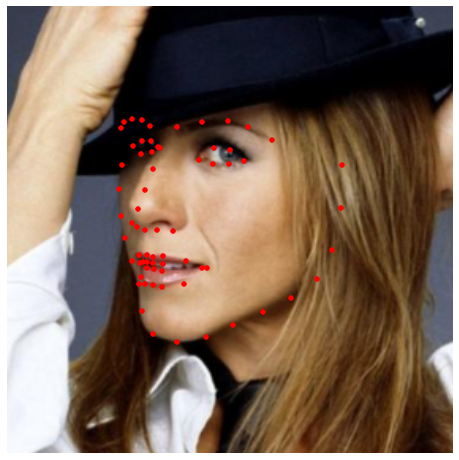

In [6]:
visualize_images(test_images)

## Fit Active Appearance Models

In [26]:
n_shape = [3, 12]
n_appearance = 0.50
max_iters = [24, 8]
scale = 0.25
noise_percentage = 0.05

repeat = 3

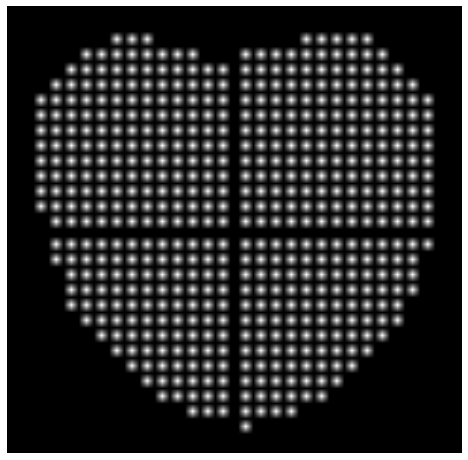

In [27]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

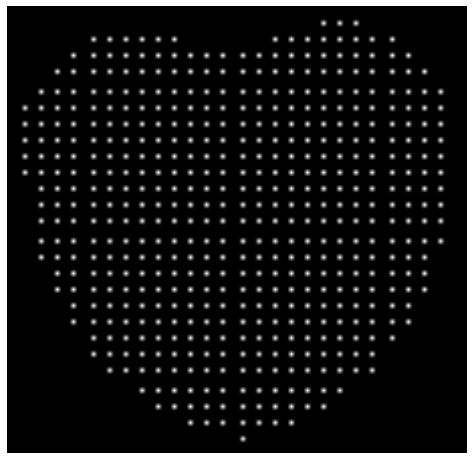

In [28]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [29]:
sampling_step = [sampling_step_1, sampling_step_2]

#### AAM Fitter

In [30]:
fitter_0 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutAsymmetricGaussNewton, l=0.1), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricGaussNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

In [31]:
sm_0 = fitter_0.aam.shape_models[0]
sm_1 = fitter_0.aam.shape_models[1]

print '1st scale -> \tvariance:', sm_0.variance_ratio(), '\tcomponents:', sm_0.n_active_components
print '2nd scale -> \tvariance:', sm_1.variance_ratio(), '\tcomponents:', sm_1.n_active_components

am_0 = fitter_0.aam.appearance_models[0]
am_1 = fitter_0.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

1st scale -> 	variance: 0.757695862498 	components: 3
2nd scale -> 	variance: 0.926468444778 	components: 12
1st scale -> 	variance: 0.500278665987 	components: 39
2nd scale -> 	variance: 0.501857013389 	components: 49


In [32]:
n_fitters = 2
legend_entries = ['Initialization', 
                  'PO_Asy_GN', 
                  'SSD_Asy_GN_Sch']

#### Fitting loop

In [33]:
fitters_results_0 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitter_0.noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)
        
    fr = fitter_0.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=0.4) 
    fr.downscale = 0.5
    fitters_results_0.append(fr.as_serializableresult())

    print_dynamic(
        'Image: {} - Initial error: {} - Final error: {}'
        .format(j, fr.initial_error(), fr.final_error()))

KeyboardInterrupt: 

In [18]:
fitters_results_1 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitter_1.noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)
        
    fr = fitter_1.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=0.2) 
    fr.downscale = 0.5
    fitters_results_1.append(fr.as_serializableresult())

    print_dynamic(
        'Image: {} - Initial error: {} - Final error: {}'

        .format(j, fr.initial_error(), fr.final_error()))

## Results

In [19]:
fitters_results = [fitters_results_0 ,
                   fitters_results_1]

In [21]:
# mio.export_pickle(fitters_results, result_folder + 'best_afw.pkl.gz')

In [ ]:
# fitters_results = mio.import_pickle(result_folder + 'best_afw.pkl.gz')

# n_fitters = 2
# legend_entries = ['Initialization', 
#                   'PO_Asy_GN', 
#                   'SSD_Asy_GN_Sch']
# max_iters = [12, 8]
# noise_percentage = 0.05

Produce CED graph:

In [22]:
errors = [[]]
for fr in fitters_results[0]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

In [23]:
x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))

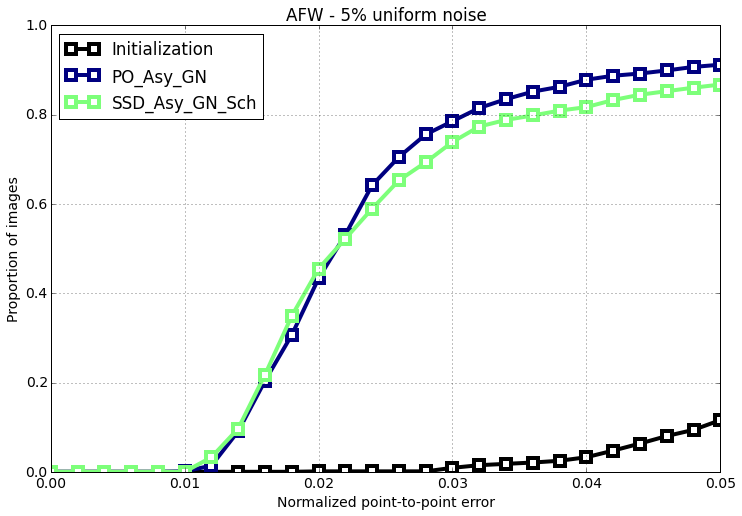

In [27]:
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
plt.legend(legend_entries, loc=2)
plt.grid(True)

plt.title('AFW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'ced_afw_{}.png'.format(int(100*noise_percentage)),  
            format='png', dpi=300)

Produce fitting statistics:

In [25]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

Initialization 	mean: 0.0839026815214 	std: 0.0301440974676 	median: 0.0806671177568
PO_Asy_GN 	mean: 0.0274034105319 	std: 0.0215704542291 	median: 0.0212969479183
SSD_Asy_GN_Sch 	mean: 0.0311426165039 	std: 0.0275744431231 	median: 0.0212707960134


Time algorithms:

In [26]:
%timeit -n 10 fr = fitter_0.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitter_1.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

10 loops, best of 3: 241 ms per loop
10 loops, best of 3: 371 ms per loop


Produce mean and median error convergence graphs:

In [28]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                         norm_shape=fr.gt_shape.points)            
            errs.append(err)
        while len(errs) < np.sum(max_iters) + aam.n_scales:
            errs.append(errs[-1])
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

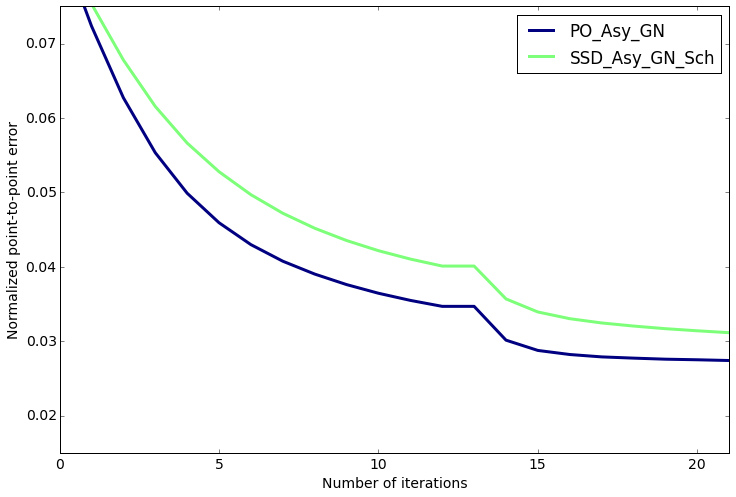

In [29]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             mean_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/mean_error_vs_iters_alpha_po_gn_0.04.png', 
            format='png', dpi=300)

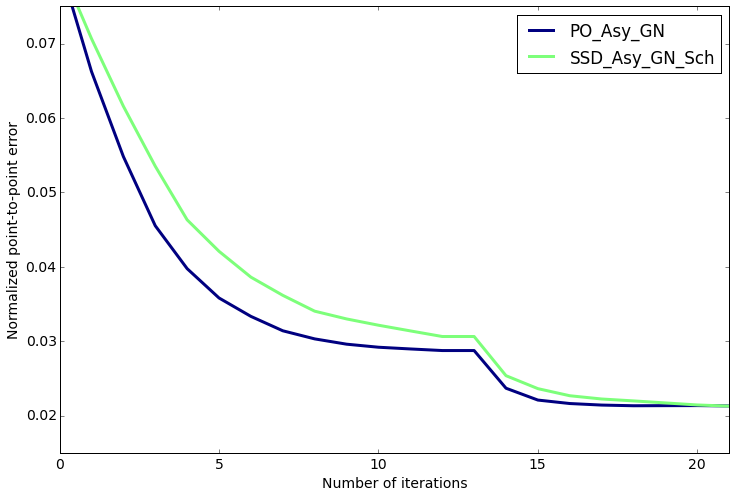

In [30]:
colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/median_error_vs_iters_alpha_po_gn_0.04.png', 
            format='png', dpi=300)

Produce mean and median cost convergence graphs:

In [32]:
mean_costs = []
std_costs = []
median_costs = []
for j in range(n_fitters):
    costs = []
    for fr in fitters_results[j]:
        cost = list(fr.costs / fr.costs[0])
        while len(cost) < np.sum(max_iters) + aam.n_scales:
            cost.append(cost[-1])
        costs.append(cost)
    costs = np.asarray(costs)
    mean_costs.append(np.mean(costs, axis=0))
    std_costs.append(np.std(costs, axis=0))
    median_costs.append(np.median(costs, axis=0))

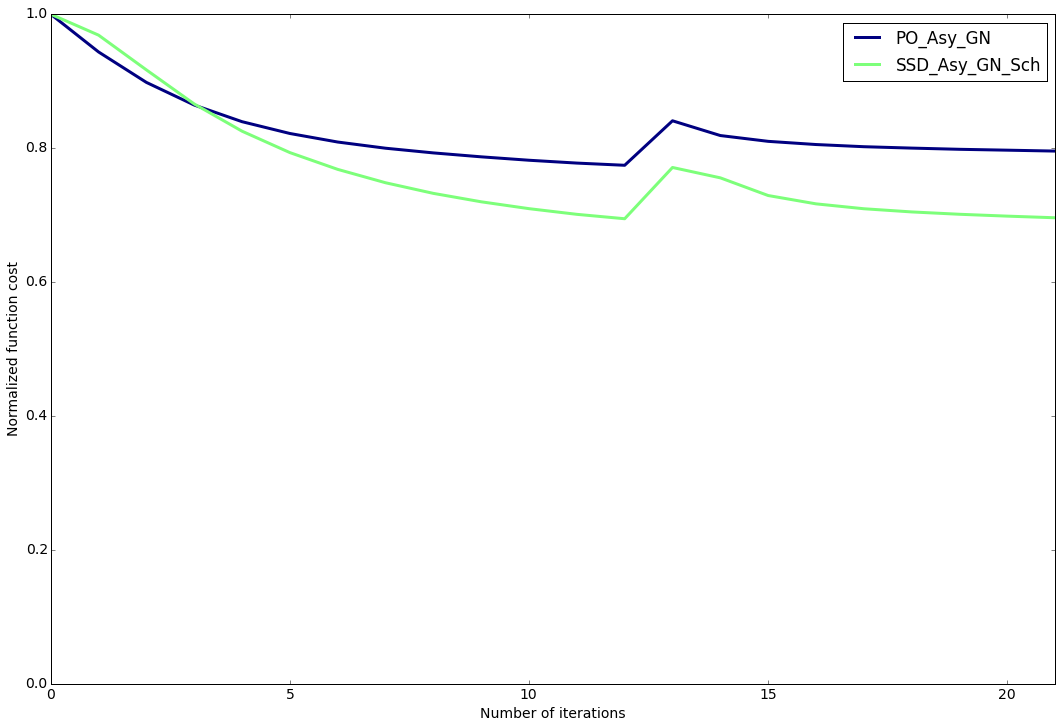

In [33]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(0, len(mean_costs[i])),
             mean_costs[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized function cost')
plt.xlim((0, len(mean_costs[i]) - 1))
plt.ylim((0, 1))
plt.legend(legend_entries[1:])

fig.set_size_inches(3 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/mean_cost_vs_iters_po_gn_0.04.png', 
            format='png', dpi=300)

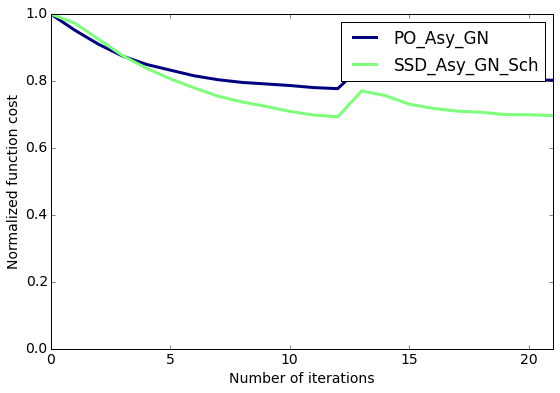

In [34]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)


for i in range(len(mean_costs)):
    plt.plot(np.arange(0, len(mean_costs[i])),
             median_costs[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized function cost')
plt.xlim((0, len(mean_costs[i]) - 1))
plt.ylim((0, 1))
plt.legend(legend_entries[1:])

fig.set_size_inches(1.5 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/median_cost_vs_iters_po_gn_0.04.png', 
            format='png', dpi=300)

Time algorithms:

In [55]:
%timeit -n 10 fr = fitter_0.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitter_1.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

10 loops, best of 3: 234 ms per loop
10 loops, best of 3: 365 ms per loop


For a particular algorithm: 

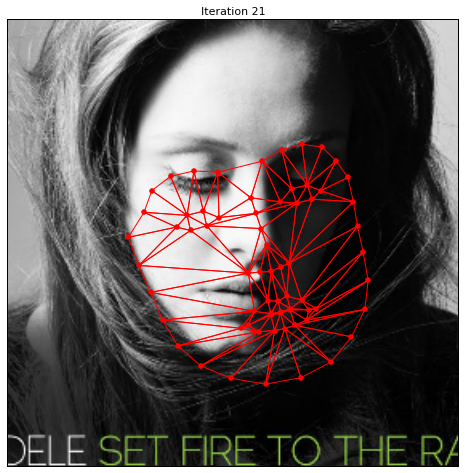

In [34]:
visualize_fitting_result(fitters_results_0)

## Other

In [27]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [28]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 